In [1]:
import anndata
import spaco

import scanpy as sc

import matplotlib
import seaborn as sns

import numpy as np
import pandas as pd
import random

from skimage import color
from spaco.utils import hex_to_rgb, lab_to_hex

In [2]:
from scipy import stats
from matplotlib import pyplot as plt

# Figure 3

## Load Data

In [3]:
adata_cellbin = anndata.read("../../data/10DPI_1_left.h5ad")

adata_cellbin.obs['annotation'] = adata_cellbin.obs['Annotation'].copy()

In [4]:
adata_cellbin.obs.head()

,CellID,spatial_leiden_e30_s8,Batch,cell_id,seurat_clusters,inj_uninj,D_V,inj_M_L,Annotation,annotation
CELL.17879,CELL.17879,2,Injury_10DPI_rep1_SS200000147BL_B5,17879,3,uninj,V,NO,VLMC,VLMC
CELL.17922,CELL.17922,2,Injury_10DPI_rep1_SS200000147BL_B5,17922,3,uninj,V,NO,VLMC,VLMC
CELL.17927,CELL.17927,2,Injury_10DPI_rep1_SS200000147BL_B5,17927,5,uninj,D,NO,VLMC,VLMC
CELL.17937,CELL.17937,6,Injury_10DPI_rep1_SS200000147BL_B5,17937,5,uninj,D,NO,VLMC,VLMC
CELL.17952,CELL.17952,2,Injury_10DPI_rep1_SS200000147BL_B5,17952,5,uninj,V,NO,VLMC,VLMC


## Filter cells

In [5]:
min_cells=10
unique_tmp = np.unique(adata_cellbin.obs['annotation'],return_counts=True)
adata_cellbin = adata_cellbin[adata_cellbin.obs['annotation'].isin(unique_tmp[0][unique_tmp[1]>min_cells])].copy()

adata_cellbin = adata_cellbin[adata_cellbin.obs['annotation']!="Unannotated"].copy()

## Figure3A

### Figure3A Default plot with Scanpy (Squidpy)

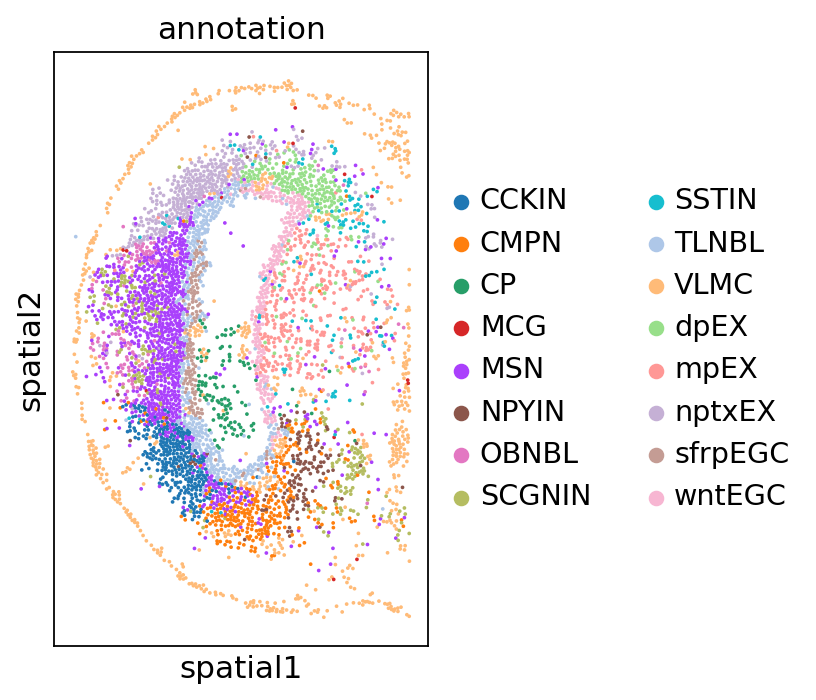

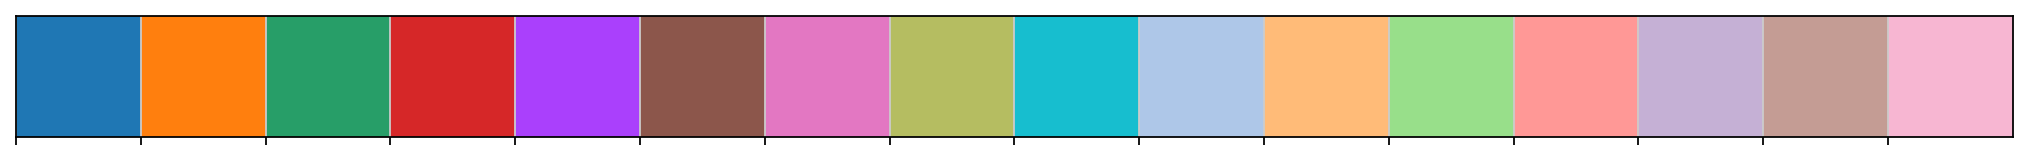

In [6]:
#--- cell_bin data
adata_cellbin.obs['annotation'] = adata_cellbin.obs['annotation'].astype(str).astype('category')

# Default colorization
sc.set_figure_params(figsize=(3,6), facecolor="white", dpi_save=300)
sc.pl.spatial(adata_cellbin, color="annotation", spot_size=35)

# Get the above (default) color palette
palette_default = adata_cellbin.uns['annotation_colors'].copy()
sns.palplot(palette_default)

### Figure3C spaco

In [7]:
cig_graph = spaco.distance.spatial_distance(
    cell_coordinates=adata_cellbin.obsm['spatial'],
    cell_labels=adata_cellbin.obs['annotation'],
    radius=120,
    n_neighbors=35,
    n_cells=3,
)

cig_graph_tmp = cig_graph.copy()
cig_graph_tmp['index'] = cig_graph_tmp.index
cig_graph_tmp.melt(id_vars=['index']).to_csv("cig.csv")

|-----------> Calculating cell neighborhood...
|-----------> Filtering out neighborhood outliers...
|-----------> Calculating cluster interlacement score...
|-----------> Constructing cluster interlacement graph...


|-----------------> Calculating cluster embedding...


/home/jingzh/.conda/envs/spaco_dev/lib/python3.8/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


|-----------------> Rescaling embedding to CIE Lab colorspace...
|-----> Optimizing cluster color mapping...


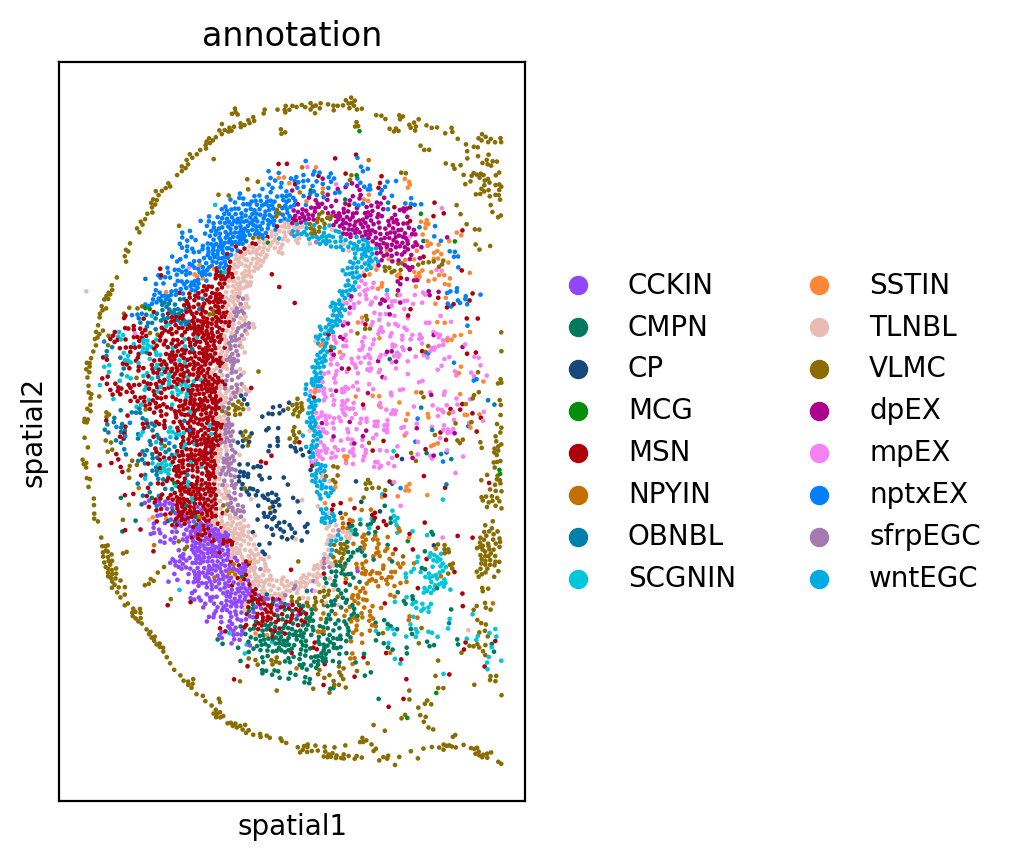

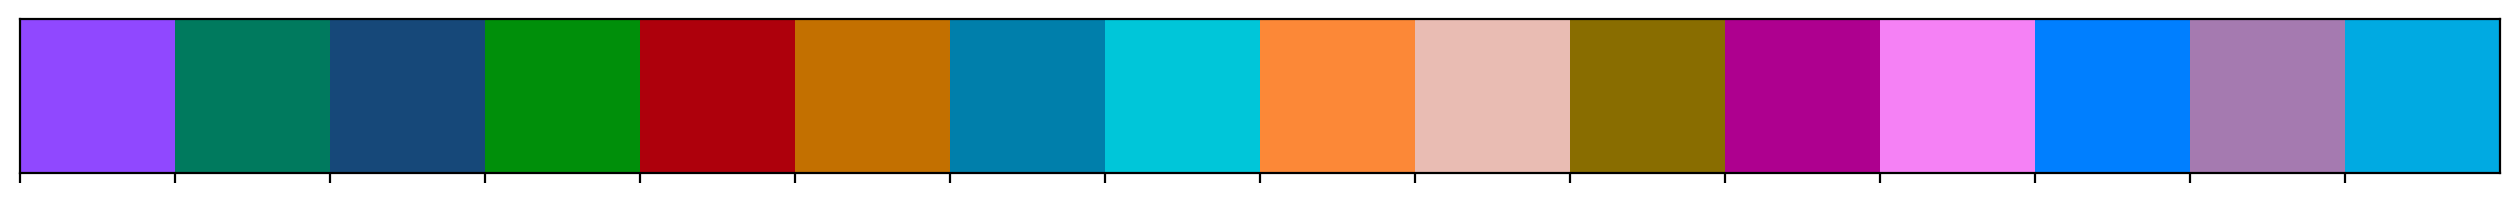

In [14]:
trim_fraction = 0.0125
l_range = (30, 80)

color_mapping = spaco.mapping.embed_graph(
    cluster_distance=cig_graph,
    #cluster_distance=np.log1p(cig_graph / np.max(cig_graph) * 100),
    l_range=l_range,
    trim_fraction=trim_fraction,
    transformation="umap",
)

# Order colors by categories in adata
color_mapping = {k: color_mapping[k] for k in adata_cellbin.obs['annotation'].cat.categories}

# Set new colors for adata
palette_umap = list(color_mapping.values())

# Spaco colorization
sc.pl.spatial(adata_cellbin, color='annotation', spot_size=35, palette=palette_umap, save="Figure4B.pdf")
sns.palplot(palette_umap)

## Figure3B density plot

|-----------> Calculating color perceptual distance...
|-----------> Constructing color distance graph...
|-----------> Calculating color perceptual distance...
|-----------> Constructing color distance graph...


<Axes: ylabel='Density'>

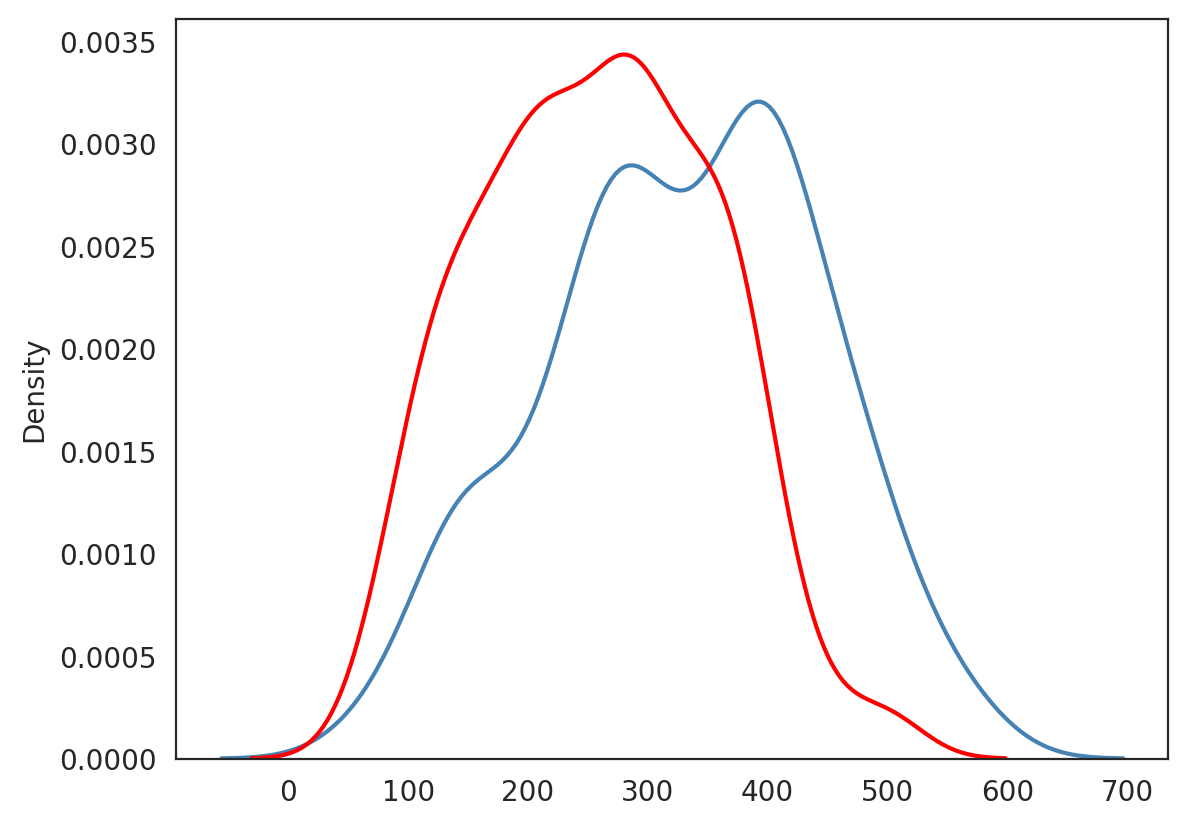

In [15]:
sns.set_style("white")
cdg_graph_umap = spaco.distance.perceptual_distance(palette_umap)
sns.kdeplot(cdg_graph_umap.to_numpy()[cdg_graph_umap!=0].ravel(), color="steelblue")
cdg_graph_default = spaco.distance.perceptual_distance(palette_default)
sns.kdeplot(cdg_graph_default.to_numpy()[cdg_graph_default!=0].ravel(),color="red")

In [16]:
stats.wilcoxon(cdg_graph_umap.to_numpy()[cdg_graph_umap!=0].ravel(), 
               cdg_graph_default.to_numpy()[cdg_graph_default!=0].ravel(),correction=True,alternative='greater')

WilcoxonResult(statistic=21823.0, pvalue=4.0074027255338256e-12)

In [17]:
stats.wilcoxon(cdg_graph_umap.to_numpy()[cdg_graph_umap!=0].ravel(), 
               cdg_graph_default.to_numpy()[cdg_graph_default!=0].ravel(),correction=True,alternative='greater')

WilcoxonResult(statistic=21823.0, pvalue=4.0074027255338256e-12)

## Figure3C palette distribution in 2D

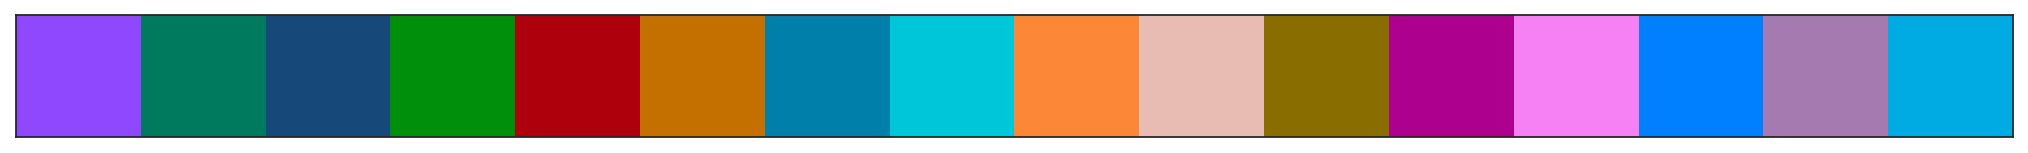

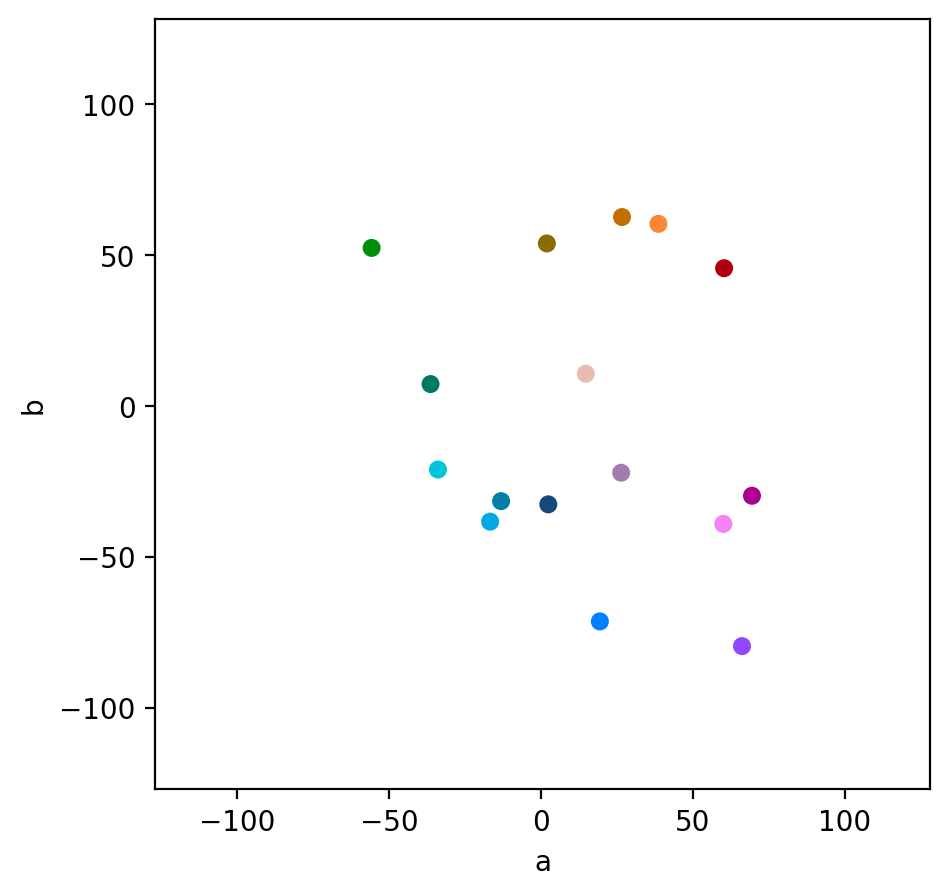

In [12]:
sns.palplot(palette_umap)
lab_spaco_umap = color.rgb2lab(np.array([hex_to_rgb(i) for i in palette_umap])/255)

df_colorset = pd.DataFrame({"L":lab_spaco_umap[:,0],
                            "a":lab_spaco_umap[:,1],
                            "b":lab_spaco_umap[:,2],
                            "RGB":palette_umap,
                            "label":cig_graph.index.to_list()})

from matplotlib import pyplot as plt
plt.style.use('default')
fig = plt.figure(figsize=(5,5))
#ax = fig.add_subplot(projection='3d')
ax = fig.add_subplot()

scat = ax.scatter(
    df_colorset['a'],
    df_colorset['b'],
    #df_colorset['L'],
    c=df_colorset['RGB'],
    s=30,
)
ax.set_xlim(-127,128)
ax.set_xlabel("a")
ax.set_ylim(-127,128)
ax.set_ylabel("b")
#ax.set_zlim(0,100)
#ax.set_zlabel("L")


#if True:
#    for i in range(len(df_colorset)):
#       ax.text(df_colorset['a'][i], df_colorset['b'][i],
#                #df_colorset['L'][i],
#                df_colorset['label'][i])

#plt.savefig("Figure4E_palette_2Ddistribution.pdf")
plt.show()

## Spplymentary Figure2C palette distribution in 3D

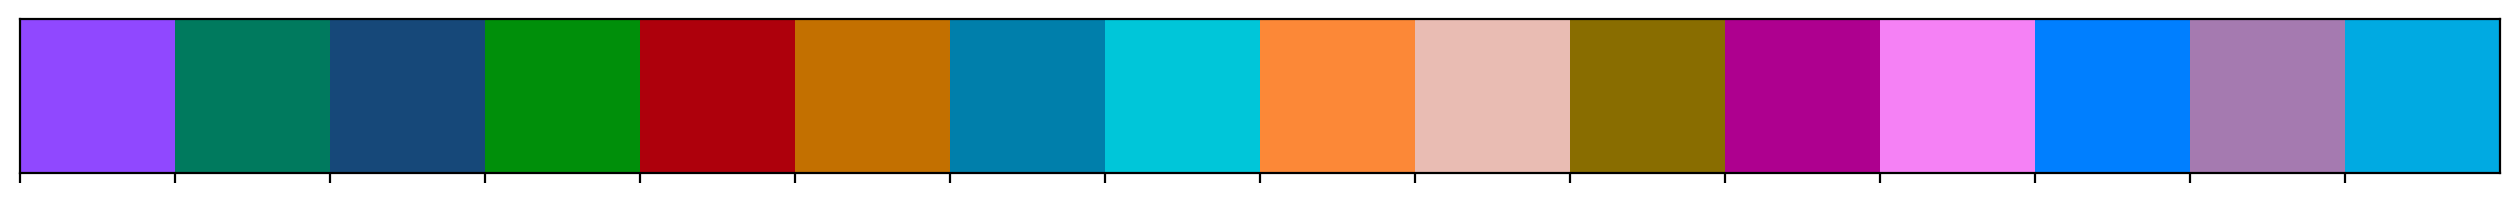

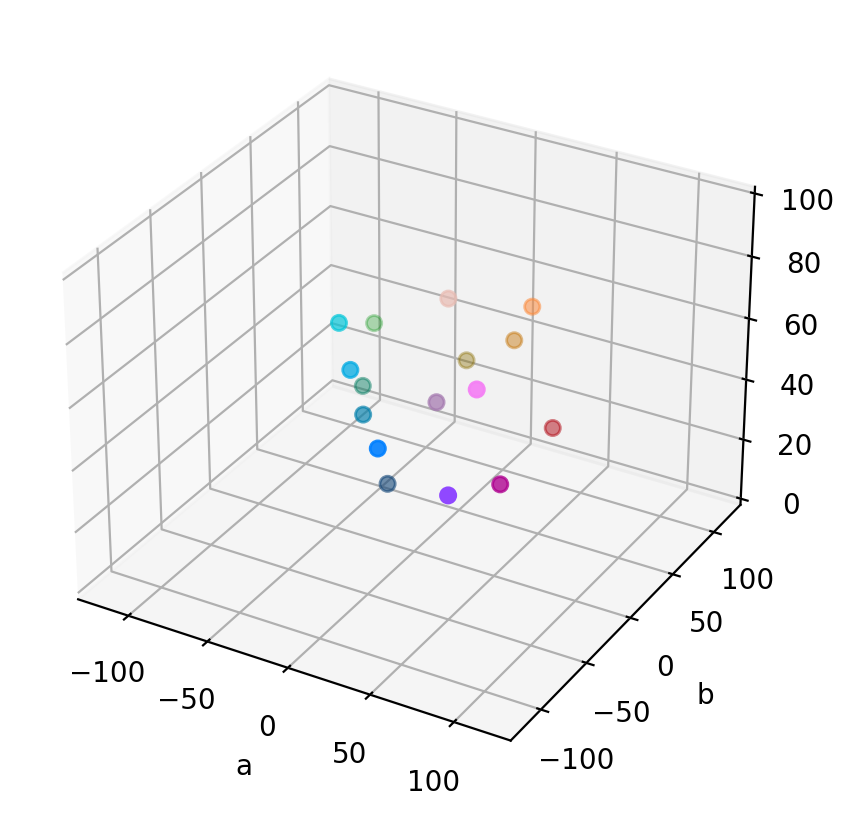

In [34]:
sns.palplot(palette_umap)
lab_spaco_umap = color.rgb2lab(np.array([hex_to_rgb(i) for i in palette_umap])/255)

df_colorset = pd.DataFrame({"L":lab_spaco_umap[:,0],
                            "a":lab_spaco_umap[:,1],
                            "b":lab_spaco_umap[:,2],
                            "RGB":palette_umap,
                            "label":cig_graph.index.to_list()})

from matplotlib import pyplot as plt
plt.style.use('default')
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')


scat = ax.scatter(
    df_colorset['a'],
    df_colorset['b'],
    df_colorset['L'],
    c=df_colorset['RGB'],
    s=30,
)
ax.set_xlim(-127,128)
ax.set_xlabel("a")
ax.set_ylim(-127,128)
ax.set_ylabel("b")
ax.set_zlim(0,100)
ax.set_zlabel("L")

#if False:
#    for i in range(len(df_colorset)):
#        ax.text(df_colorset['a'][i], df_colorset['b'][i],
#                df_colorset['L'][i],
#               df_colorset['label'][i])
      
#ax.view_init(45, 45, 0)
plt.savefig("Figure4E_palette_3Ddistribution.pdf")

plt.show()

## Figure3D spatial plot of distant clusters

In [19]:
cell_labels = np.unique(adata_cellbin.obs['annotation'])
#color_mapping_default = {cell_labels[k]:palette_default[k] for k in range(len(cell_labels))}
#color_mapping_random = {cell_labels[k]:palette_random[k] for k in range(len(cell_labels))}
#color_mapping_palo = {cell_labels[k]:palette_palo[k] for k in range(len(cell_labels))}
#color_mapping_umap = {palette_umap[k]:cell_labels[k] for k in range(len(cell_labels))}
color_mapping_spaco = {cell_labels[k]:palette_umap[k] for k in range(len(cell_labels))}

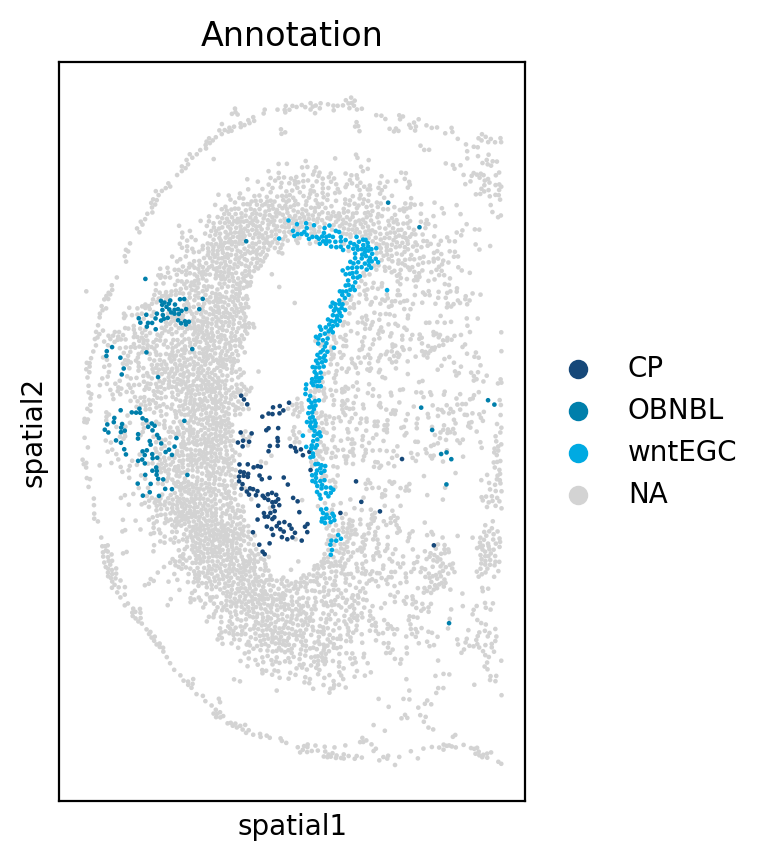

In [20]:
sc.pl.spatial(adata_cellbin, groups=['OBNBL','wntEGC','CP'],
              color="Annotation", spot_size=35, palette=color_mapping_spaco,
             save="Figure4F_distant_clusters_highlight.pdf")

## Figure3E,F,G color extracting

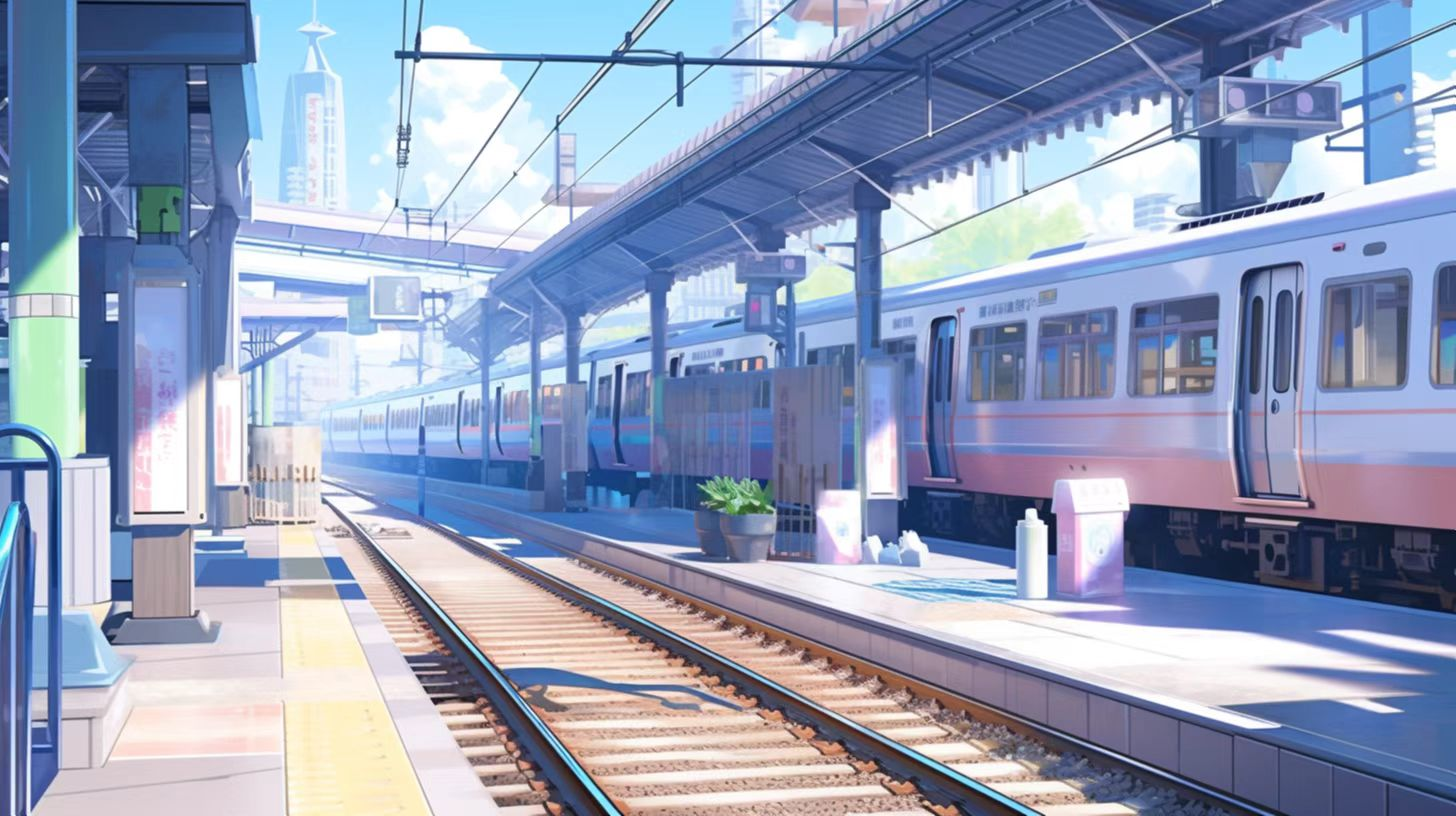

In [23]:
from PIL import Image

#img = Image.open("./figures/abc.jpg").convert("RGB")
img = Image.open("./figures/target_picture.jpg").convert("RGB")
img

In [24]:
from skimage import color
from spaco.utils import _get_bin_color, lab_to_hex, hex_to_rgb

l_range=(0, 100)
trim_percentile = 0.03

lab_image = color.rgb2lab(img)

# Make L, A, B into 20 bins each.
bin_index_l = (lab_image[:, :, 0] / 5).astype(int)
bin_index_a = (lambda x: (x + 127) / 2.55 / 5)(lab_image[:, :, 1]).astype(int)
bin_index_b = (lambda x: (x + 127) / 2.55 / 5)(lab_image[:, :, 2]).astype(int)
bin_index_l[bin_index_l == 20] = 19
bin_index_a[bin_index_a == 20] = 19
bin_index_b[bin_index_b == 20] = 19

# Get bin freqency
numbered_bin_colors = bin_index_l * 400 + bin_index_a * 20 + bin_index_b
bin_color_set, bin_color_count = np.unique(
    numbered_bin_colors.ravel(), return_counts=True
)

# Truncate color set by l_range, filter out infrequent colors
filter = (
    (bin_color_set > l_range[0] / 5 * 400)
    & (bin_color_set < l_range[1] / 5 * 400)
    & (bin_color_count > np.quantile(bin_color_count, trim_percentile))
)
bin_color_set = bin_color_set[filter]
bin_color_count = bin_color_count[filter]

lab_color_set = np.frompyfunc(_get_bin_color, 1, 1)(bin_color_set)

In [25]:
df_colorset = pd.DataFrame({"L":[i[0] for i in lab_color_set],
                            "a":[i[1] for i in lab_color_set],
                            "b":[i[2] for i in lab_color_set],
                            "RGB":[lab_to_hex(i) for i in lab_color_set],
                            "Freq":np.log(bin_color_count)})
df_colorset["R"] = [hex_to_rgb(i)[0] for i in df_colorset['RGB']]
df_colorset["G"] = [hex_to_rgb(i)[1] for i in df_colorset['RGB']]
df_colorset["B"] = [hex_to_rgb(i)[2] for i in df_colorset['RGB']]

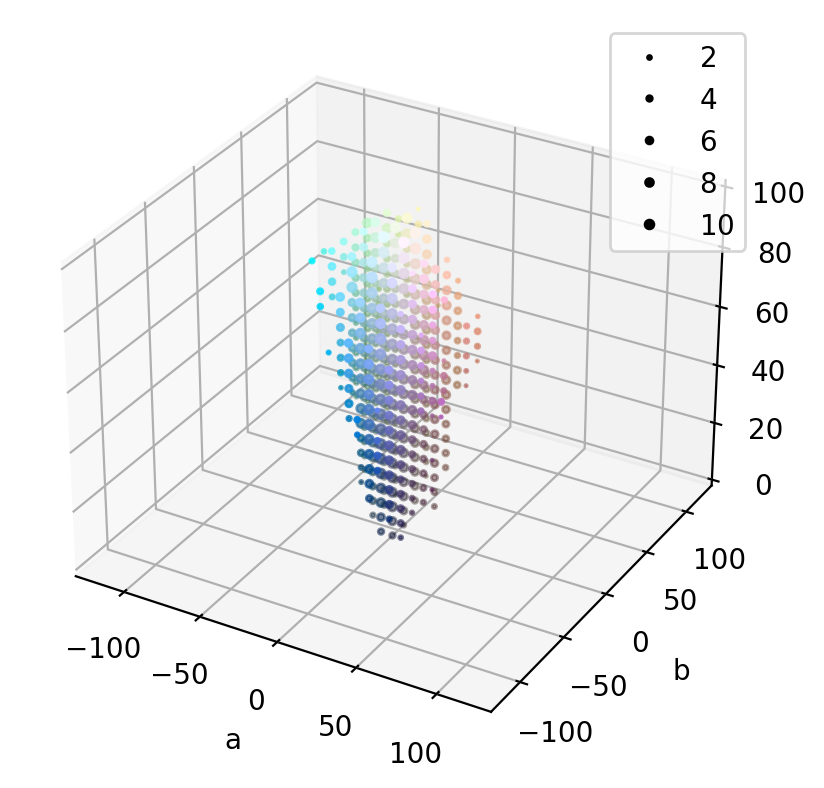

In [26]:
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [10, 5]
plt.style.use('default')
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

scat = ax.scatter(
    df_colorset['a'],
    df_colorset['b'],
    df_colorset['L'],
    s=df_colorset['Freq'],
    c=df_colorset['RGB'],
)
ax.set_xlim(-127,128)
ax.set_xlabel("a")
ax.set_ylim(-127,128)
ax.set_ylabel("b")
ax.set_zlim(0,100)
ax.set_zlabel("L")
plt.legend(*scat.legend_elements("sizes", num=6))
plt.show()

|-----------------> Extracting color bins...
|-----------------> Initiating palette...
|-----------------> Optimizing extracted palette...
|-----------> Calculating color perceptual distance...
|-----------> Constructing color distance graph...


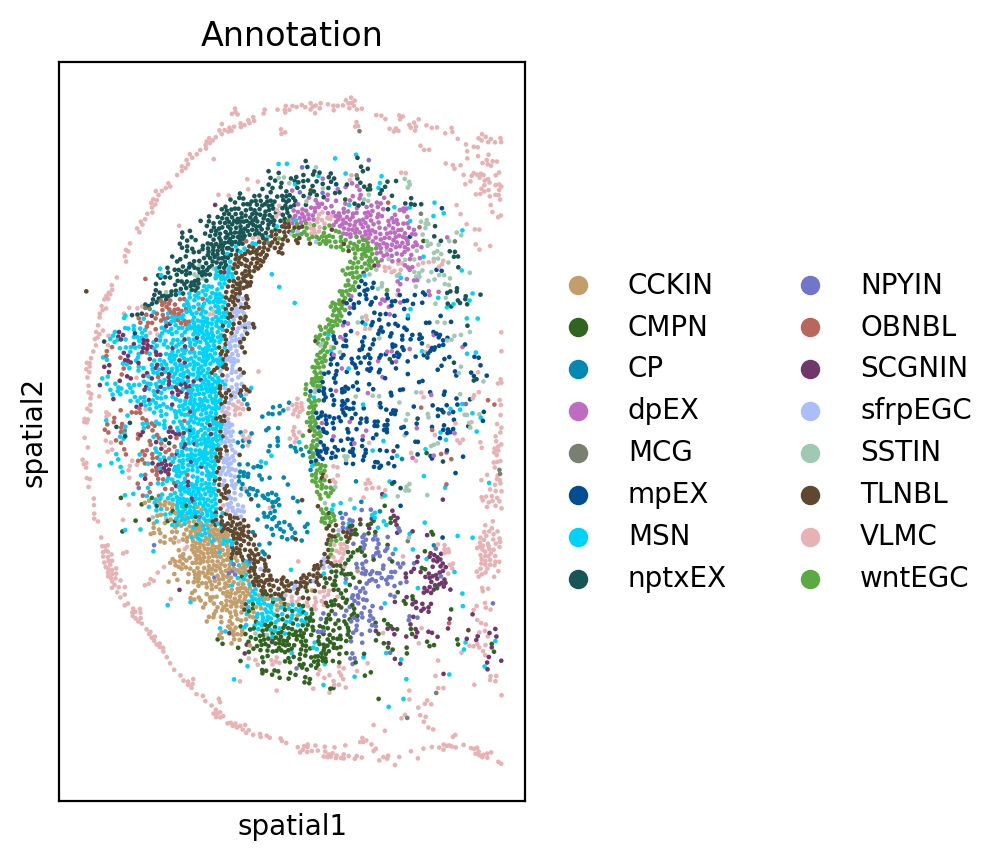

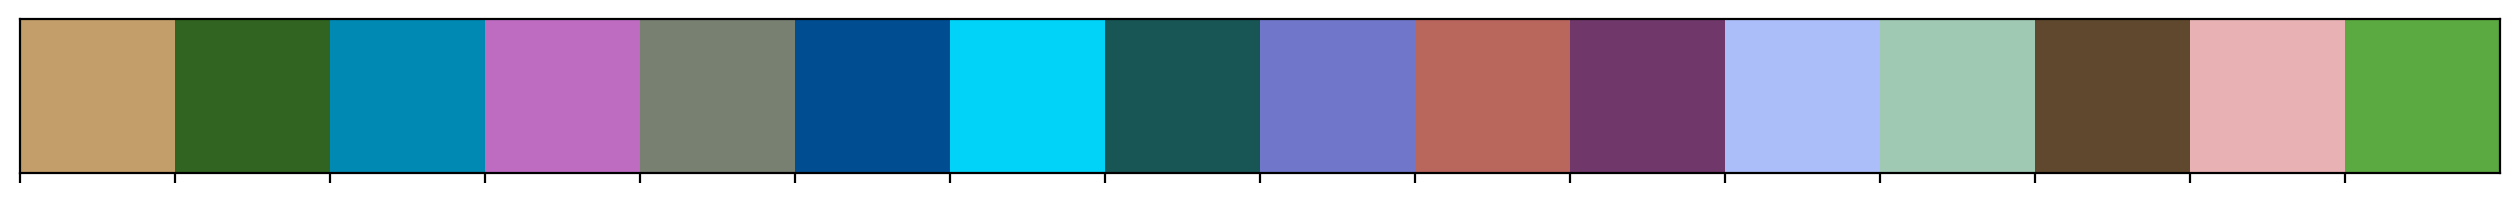

In [27]:
palette_img = spaco.utils.extract_palette(reference_image=img,n_colors=len(palette_default),l_range=(30,80))

color_mapping = spaco.mapping.map_graph(cig_graph,spaco.distance.perceptual_distance(palette_img), 
                                        distance_metric="mul_1", random_max_iter=5000)

color_mapping = {k: color_mapping[k] for k in adata_cellbin.obs['Annotation'].cat.categories}

# Set new colors for adata
palette_img = list(color_mapping.values())

# Spaco colorization
sc.pl.spatial(adata_cellbin, color="Annotation", spot_size=35, palette=palette_img,)
              #save="Figure4B_spaco_deault.pdf")
sns.palplot(palette_img)

## Figure3H color value distance

In [28]:
cell_labels = np.unique(adata_cellbin.obs['annotation'])
color_mapping_default = {cell_labels[k]:palette_default[k] for k in range(len(cell_labels))}
#color_mapping_random = {cell_labels[k]:palette_random[k] for k in range(len(cell_labels))}
#color_mapping_palo = {cell_labels[k]:palette_palo[k] for k in range(len(cell_labels))}
#color_mapping_umap = {palette_umap[k]:cell_labels[k] for k in range(len(cell_labels))}
color_mapping_img = {cell_labels[k]:palette_img[k] for k in range(len(cell_labels))}

In [29]:
img_cpd = spaco.distance.perceptual_distance(palette_img)
img_cpd_tmp = img_cpd.copy()
img_cpd_tmp['index'] = img_cpd_tmp.index
img_df = img_cpd_tmp.melt(id_vars=['index'])
img_df.to_csv("img_color_perceptual_differences.csv")
img_df['source'] = "img"
#for i in range(cellpair.shape[0]):
#    cellpair.loc[i, "spaco_cpd"] = spaco_cpd.loc[cellpair.loc[i,"spaco_col1"],cellpair.loc[i,"spaco_col2"]]

|-----------> Calculating color perceptual distance...
|-----------> Constructing color distance graph...


In [30]:
default_cpd = spaco.distance.perceptual_distance(palette_default)
default_cpd_tmp = default_cpd.copy()
default_cpd_tmp['index'] = default_cpd_tmp.index
default_df = default_cpd_tmp.melt(id_vars=['index'])
default_df.to_csv("default_color_perceptual_differences.csv")
default_df['source'] = "default"
#for i in range(cellpair.shape[0]):
#    cellpair.loc[i, "spaco_cpd"] = spaco_cpd.loc[cellpair.loc[i,"spaco_col1"],cellpair.loc[i,"spaco_col2"]]

|-----------> Calculating color perceptual distance...
|-----------> Constructing color distance graph...


In [31]:
df = pd.concat([img_df,default_df])

(array([0, 1]), [Text(0, 0, 'img'), Text(1, 0, 'default')])

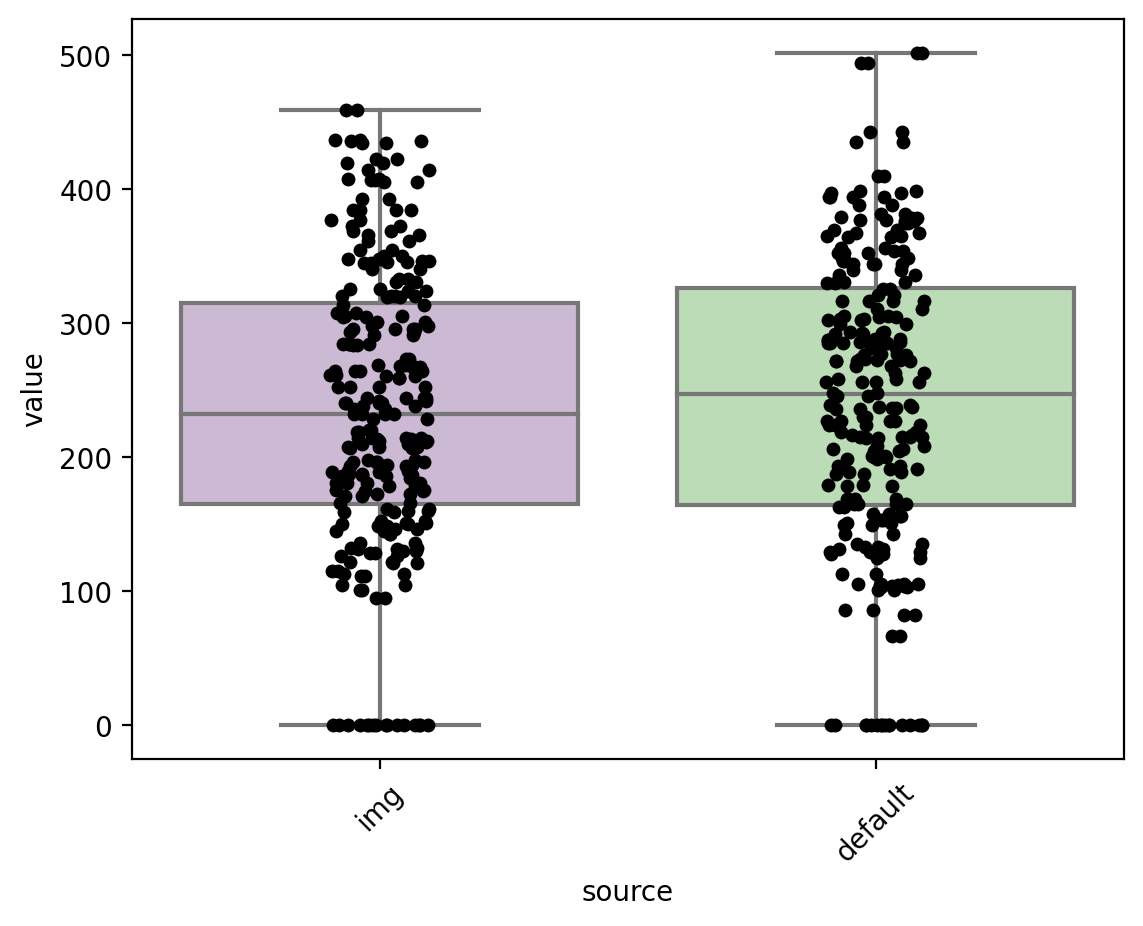

In [32]:
plt.figure()
fig = sns.boxplot(x="source", y="value", data=df, palette="PRGn") 
fig = sns.stripplot(x = "source", y = "value", color = 'black', dodge=True,
                      data = df)
plt.xticks(rotation=45)

In [33]:
stats.wilcoxon(default_df['value'], img_df['value'],correction=True,alternative='two-sided')

WilcoxonResult(statistic=13638.0, pvalue=0.44545838730972975)

In [1]:
import session_info


session_info.show(excludes=['base'])